# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

In [3]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [5]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.f39b54f43cd042239cbff60f53f30f37 Dashboard: /services/dask-gateway/clusters/prod.f39b54f43cd042239cbff60f53f30f37/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [6]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [7]:
xr.set_options(display_style='text')

In [36]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb
ds = xr.merge([ds_tns, ds_tmp_slt_wg, ds_vel])
ds

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

<xarray.Dataset>
Dimensions:                   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float64 0.08333 0.25 0.4167 ... 359.8 359.9
  * YC                        (YC) float64 -77.87 -77.71 ... -24.87 -24.71
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                        (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [37]:
ds_tns_rolled = ds_tns.roll(XC=700)
ds_vel_rolled = ds_vel.roll(XC=700, XG=700)

<ipython-input-37-8c827acd8b2d>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_tns_rolled = ds_tns.roll(XC=700)
<ipython-input-37-8c827acd8b2d>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_vel_rolled = ds_vel.roll(XC=700, XG=700)


In [38]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
#WG model's boundaries after .roll(XC=700) (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #YG=-77.9583
upper_lat = 95
left_lon =  310
right_lon = 880

YG_upper = 96 #-61.9583
#XG_left = 311 #295.1667
XG_right = 881 #30.166668

In [39]:
#set the boundaries
lat_range_noface = dict(YC=slice(lower_lat, upper_lat))
lon_range_noface = dict(XC=slice(left_lon, right_lon))

lat_range = dict(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, YG_upper))
lon_range = dict(XC=slice(left_lon, right_lon), XG=slice(left_lon, XG_right))

In [40]:
ds_tns_wg = ds_tns_rolled.isel(**lat_range_noface, **lon_range_noface)
ds_vel_wg = ds_vel_rolled.isel(**lat_range, **lon_range)

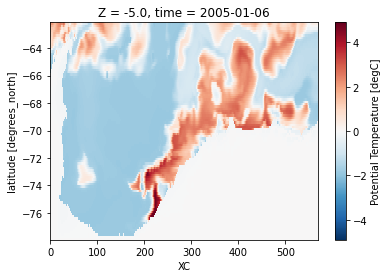

In [44]:
ds_tns_wg.THETA[0,0].drop('XC').plot()

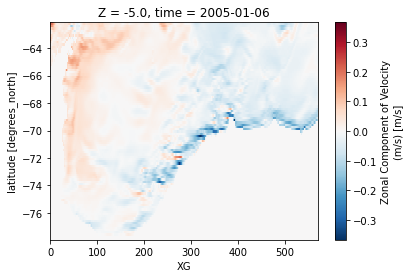

In [51]:
ds_vel_wg.UVEL[0,0].drop('XG').plot()

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial t} \end{equation*} </font>

In [7]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, ds.Z, ds.YC, 
                          output_dtypes=[ds.Z],
                          dask='parallelized').reset_coords(drop=True).load()

In [25]:
drhodt = jmd95numba.drhodt(ds.SALT, ds.THETA, pressure)
drhodt

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<drhodt, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [26]:
mean = drhodt.mean(dim=['time', 'Z'])

In [27]:
mean

<xarray.DataArray (YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(95, 570), dtype=float64, chunksize=(95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083

In [18]:
mean.plot()

AttributeError: module '__mp_main__' has no attribute 'drhodt'

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [9]:
drhods = jmd95numba.drhods(ds.SALT, ds.THETA, pressure)
drhods

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<drhods, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31